# <hr>
<h1><center> Analyse de sentiments sur des tweets</center></h1>

<hr>
<h2><center>Modélisation</center></h2>
<br>

>__Réalisé par : Said Arrazouaki__


>__email : sarrazouaki@gmail.com__

# Introduction

Dans le cadre de notre mission en tant qu’ingénieur IA pour la société MIC (Marketing Intelligence Consulting), nous sommes sollicités par la compagnie aérienne Air Paradis afin de concevoir un prototype d’intelligence artificielle capable de prédire le sentiment associé à un tweet. L’objectif est d’anticiper d’éventuels bad buzz et d’améliorer la réactivité de l’entreprise face aux crises potentielles sur les réseaux sociaux.

Ce notebook présente la première phase du projet : l’étude comparative de trois approches de modélisation pour la tâche de classification binaire (sentiment positif vs. négatif) sur des données textuelles issues de tweets. Ces trois approches sont les suivantes :

- **Approche 1 :** Modèle classique utilisant une vectorisation TF-IDF combinée à une régression logistique.

- **Approche 2 :** Modèle avancé basé sur un réseau de neurones LSTM, enrichi par des embeddings pré-entraînés GloVe.

- **Approche 3 :** Modèle de pointe reposant sur le fine-tuning du modèle pré-entraîné BERT (transformers, Hugging Face).

Chaque modèle sera entraîné, évalué et comparé en termes de performances. Un suivi rigoureux des expérimentations sera assuré à l’aide de l’outil MLFlow, dans une démarche orientée MLOps qui sera approfondie dans les étapes ultérieures du projet.

# Chargement et exploration des données

In [ ]:
import os
import re
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

In [ ]:
# Se connecter a drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
path = '/content/drive/MyDrive/Openclassrooms/Projet-7/'
sys.path.append(path)

In [ ]:
from utils import preprocess_tweet, preprocess_tweet_bert

In [ ]:
!pip install mlflow

In [ ]:
import mlflow

# Utiliser un dossier temporaire local (propre, sans Google Drive)
mlflow_tracking_dir = path + "mlruns"
os.makedirs(mlflow_tracking_dir, exist_ok=True)

mlflow.set_tracking_uri(f"file:{mlflow_tracking_dir}")

In [ ]:
# Chargement du data
data = pd.read_csv(path+'data/data_brute.csv', encoding='latin-1', header=None)

In [ ]:
data.columns = ['target', 'id', 'date', 'query', 'user', 'tweet']
data.head(2)

,target,id,date,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


In [ ]:
data = data[['tweet', 'target']]
data.head(2)

,tweet,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0


In [ ]:
data.target.value_counts()

,count
target,
0,800000
4,800000


In [ ]:
data['target'] = data['target'].replace(4, 1)

In [ ]:
data.target.value_counts()

,count
target,
0,800000
1,800000


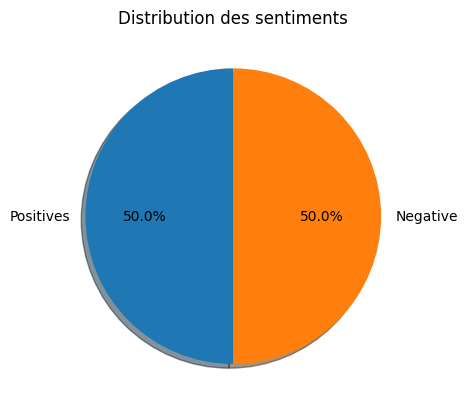

In [ ]:
labels = 'Positives', 'Negative'
data.target.value_counts().plot(kind='pie', labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.title('Distribution des sentiments')
plt.ylabel('')
plt.show()

Avant de commencer, affichons quelques tweets pour voir à quoi ils ressemblent. Cela permet d’identifier ce qu’il faudra nettoyer ou transformer.
Ci-dessous, on affiche un tweet positif (en vert) et un tweet négatif (en rouge), choisis au hasard.

In [ ]:
# Afficher un tweet positif en vert
print()
print('\033[92m' + data.loc[data.target == 1, 'tweet'].sample(1).values[0])

# Afficher un tweet négatif en rouge
print()
print('\033[91m' + data.loc[data.target == 0, 'tweet'].sample(1).values[0])


Waiting to get home. I might call Ali if I can stay awake 

and my pillow 


# Prétraitement des données textuelles

Le prétraitement des données est une étape essentielle dans tout projet de machine learning. Pour le traitement du langage naturel (NLP), cela consiste à nettoyer et formater les textes avant de les utiliser dans un modèle.

Voici les principales étapes de prétraitement :

- Tokenisation (découper le texte en mots),

- Mise en minuscules,

- Suppression des stop words et de la ponctuation,

- Stemmatisation (réduction des mots à leur racine).

Nous allons appliquer ces étapes à un tweet pour observer concrètement comment le texte brut est transformé.

In [ ]:
# Un exemple de tweet
tweet = data.loc[data.target == 0, 'tweet'].values[0]
print(tweet)

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D


Comme nos données proviennent de Twitter, il est utile de nettoyer certains éléments spécifiques à cette plateforme :

- les marques de retweet (RT),

- les liens hypertextes,

- les symboles # et @.

Pour cela, on utilise la bibliothèque ``re`` et des expressions régulières afin de remplacer ces éléments par du vide ('').

In [ ]:
# Affichage du tweet original
print()
print('\033[92m' + tweet)
print('\033[94m')

# Suppression de "RT" au début du tweet
tweet2 = re.sub(r'^RT[\s]+', '', tweet)

# Suppression des liens
tweet2 = re.sub(r'https?://[^\s\n\r]+', '', tweet2)

# Suppression des symboles # et @
tweet2 = re.sub(r'#', '', tweet2)
tweet2 = re.sub(r'@\w+', '', tweet2)

# Affichage du tweet nettoyé
print()
print(tweet2)


@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D


  - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D


La tokenisation consiste à découper le texte en mots, en supprimant les espaces et les tabulations.
On en profite aussi pour mettre tous les mots en minuscules.
La bibliothèque NLTK permet de faire ça facilement avec le module tokenize.

In [ ]:
print()
print('\033[92m' + tweet2)
print('\033[94m')

# Création du tokenizer
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

# Découpage du tweet en mots (tokenisation)
tweet_tokens = tokenizer.tokenize(tweet2)

print()
print('Tweet tokenisé :')
print(tweet_tokens)


  - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D


Tweet tokenisé :
['-', 'awww', ',', "that's", 'a', 'bummer', '.', 'you', 'shoulda', 'got', 'david', 'carr', 'of', 'third', 'day', 'to', 'do', 'it', '.', ';D']


L’étape suivante consiste à supprimer les stop words (mots très fréquents sans valeur informative comme "the", "is", "at", etc.) ainsi que la ponctuation.
La bibliothèque NLTK fournit une liste de stop words en anglais que nous allons utiliser.

In [ ]:
# Télécharger les stopwords depuis NLTK
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Importer la liste des stop words anglais depuis NLTK
stopwords_english = stopwords.words('english')

print('Stop words :\n')
print(stopwords_english)

print('\nPonctuation :\n')
print(string.punctuation)

Stop words :

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', 

Certaines stop words comme i, not ou because peuvent parfois être utiles selon le contexte.
Mais pour les premiers modèles, nous utiliserons toute la liste par défaut.

Concernant la ponctuation, certains symboles comme :) ou ... peuvent exprimer des émotions dans un tweet.

Passons maintenant au nettoyage de notre tweet tokenisé !

In [ ]:
print()
print('\033[92m')
print(tweet_tokens)
print('\033[94m')

tweets_clean = []

# Parcours de chaque mot du tweet tokenisé
for word in tweet_tokens:
    if (word not in stopwords_english and
        word not in string.punctuation):
        tweets_clean.append(word)

print('Stop words et ponctuation supprimés :')
print(tweets_clean)



['-', 'awww', ',', "that's", 'a', 'bummer', '.', 'you', 'shoulda', 'got', 'david', 'carr', 'of', 'third', 'day', 'to', 'do', 'it', '.', ';D']

Stop words et ponctuation supprimés :
['awww', "that's", 'bummer', 'shoulda', 'got', 'david', 'carr', 'third', 'day', ';D']


Le stemming consiste à réduire un mot à sa forme de base (ou racine).
Cela permet de réduire la taille du vocabulaire et de regrouper les variantes d’un même mot (ex. playing, played → play).

In [ ]:
print()
print('\033[92m')
print(tweets_clean)
print('\033[94m')

# Création de l'outil de stemming
stemmer = PorterStemmer()

# Liste vide pour stocker les racines
tweets_stem = []

# Appliquer le stemming à chaque mot
for word in tweets_clean:
    stem_word = stemmer.stem(word)
    tweets_stem.append(stem_word)

print('Mots après stemming :')
print(tweets_stem)



['awww', "that's", 'bummer', 'shoulda', 'got', 'david', 'carr', 'third', 'day', ';D']

Mots après stemming :
['awww', "that'", 'bummer', 'shoulda', 'got', 'david', 'carr', 'third', 'day', ';d']


Nous avons maintenant une liste de mots nettoyés et préparés, prête à être utilisée pour la suite de notre projet.

Comme nous l'avons vu, le prétraitement d’un tweet passe par plusieurs étapes successives : nettoyage, tokenisation, suppression des stop words, ponctuation, et stemming.

Plutôt que de répéter ce code à chaque fois, nous allons maintenant regrouper toutes ces étapes dans une seule fonction appelée pretraiter_tweet(tweet).

Cela permettra de simplifier notre pipeline et de réutiliser facilement le même traitement sur tous les tweets de notre jeu de données. Faisons cela dans la cellule suivante.

In [ ]:
print()
print('\033[92m')
print(tweet)


# Appel de la fonction de prétraitement
tweets_stem = preprocess_tweet(tweet)

print('\033[94m')
print('Tweet prétraité :')
print(tweets_stem)



@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D

Tweet prétraité :
['awww', "that'", 'bummer', 'shoulda', 'got', 'david', 'carr', 'third', 'day', ';d']


In [ ]:
# data["clean_tweet"] = data['tweet'].apply(lambda t: preprocess_tweet(t, rejoin=True))

In [ ]:
# # Application sur DataFrame
# data["clean_tweet_bert"] = data["tweet"].apply(preprocess_tweet_bert)

In [ ]:
# data = data[['tweet', 'clean_tweet', 'clean_tweet_bert', 'target']]
# data.head(2)

In [ ]:
# data.to_csv(path+'data/data_clean.csv', index=False)

# Approche 1 – Modèle simple : régression logistique

In [ ]:
import mlflow.sklearn
from mlflow.models.signature import infer_signature

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
df = pd.read_csv(path+'data/data_clean.csv')

In [ ]:
df = df[['tweet', 'clean_tweet', 'target']]

In [ ]:
df.head(2)

,tweet,clean_tweet,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww that' bummer shoulda got david carr third...,0
1,is upset that he can't update his Facebook by ...,upset can't updat facebook text ... might cri ...,0


In [ ]:
df.isna().sum()

,0
tweet,0
clean_tweet,7042
target,0


In [ ]:
df.loc[df.clean_tweet.isna(), 'tweet'].head(10)

,tweet
208,@mandayyy
249,@mandayyy
282,@ITS_NEMESIS -------
398,@danadearmond
430,@anistorm
555,@phlaimeaux where are you?
614,@thousand_miles no
1011,@citizensheep
1014,@GirlsGoneChild
1185,@almostcool i'm off now


In [ ]:
df.dropna(subset=['clean_tweet'], inplace=True)

In [ ]:
# duplicated
df.duplicated().sum()

np.int64(16143)

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
X = df['clean_tweet']
y = df['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
X_train.shape

(1419133,)

In [ ]:
X_test.shape

(157682,)

In [ ]:
# --- Définir les hyperparamètres ---
max_features = 20000
C = 1
max_iter = 1000


In [ ]:
# --- Pipeline ---
bow = CountVectorizer(max_features=max_features)
tfidf = TfidfVectorizer(max_features=max_features)
clf = LogisticRegression(C=C, max_iter=max_iter)

pipeline = Pipeline([
    ("tfidf", tfidf),
    ("clf", clf)
])

In [ ]:
mlflow.set_experiment("Logistic regression")

with mlflow.start_run(run_name="LR with TFIDF") as run:

    # Entraînement
    pipeline.fit(X_train, y_train)

    # Prédiction
    y_pred = pipeline.predict(X_test)

    # Logging des paramètres
    mlflow.log_param("tfidf_max_features", max_features)
    mlflow.log_param("logreg_C", C)
    mlflow.log_param("logreg_max_iter", max_iter)

    # Log des métriques
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)


    # Log tags descriptifs
    mlflow.set_tag("model_type", "Linear")
    mlflow.set_tag("vectorizer", "TfidfVectorizer")

    # Exemple de texte que ton modèle peut prédire
    example_input = pd.DataFrame({"clean_tweet": ["I like this product"]})
    signature=mlflow.models.infer_signature(example_input, pipeline.predict(example_input))

    mlflow.sklearn.log_model(
        sk_model=pipeline,
        artifact_path="model_tfidf",
        input_example=example_input,
        signature=signature
    )
    print("Run MLflow terminé avec succès")

Run MLflow terminé avec succès


In [ ]:
acc

0.7746413668015373

In [ ]:
recall

0.7923240023222354

In [ ]:
f1

0.77941313402817

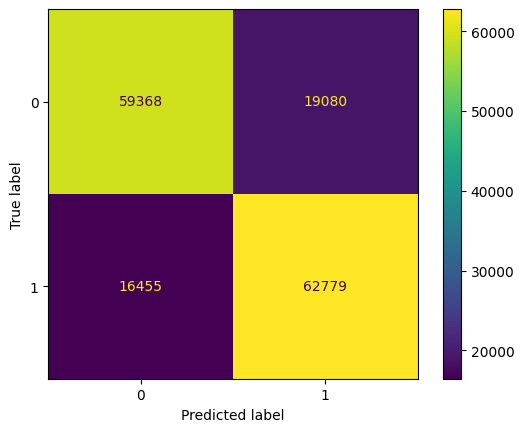

In [ ]:
# display matrice de confusion
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)
plt.show()

In [ ]:
dossier = path + "models"
os.makedirs(dossier, exist_ok=True)

In [ ]:
import pickle

chemin_fichier = os.path.join(dossier, "mon_pipeline.pkl")

# Enregistrement
with open(chemin_fichier, 'wb') as f:
    pickle.dump(pipeline, f)

# Approche 2 – Réseaux de neurones LSTM

Pour aller au-delà des performances d’un modèle classique, nous avons conçu un modèle sur mesure avancé basé sur les réseaux de neurones profonds. L’objectif était de tirer parti de la puissance du deep learning pour capter les subtilités du langage naturel dans les tweets, notamment les nuances émotionnelles qui peuvent être difficiles à modéliser avec des approches plus simples.

**Architectures choisies**

Nous avons expérimenté deux architectures basées sur des réseaux de neurones récurrents (RNN) avec des couches LSTM (Long Short-Term Memory), en utilisant l’API Keras de TensorFlow. Les LSTM sont particulièrement bien adaptés à l’analyse de texte, car ils permettent de capturer des dépendances contextuelles à long terme dans les séquences de mots.

Les deux variantes testées sont :

1. Architecture avec couche d’Embedding entraînée pendant l’apprentissage
Dans cette version, les vecteurs de mots sont initialisés aléatoirement et optimisés au cours de l’entraînement. Cela permet au modèle de construire des représentations spécifiques aux données de sentiment analysées.

2. Architecture avec vecteurs GloVe pré-entraînés
Ici, nous utilisons des vecteurs de mots issus de GloVe (Global Vectors for Word Representation), qui apportent une connaissance sémantique préexistante basée sur de larges corpus de texte.

Les deux architectures partagent une structure similaire :

- Une couche Embedding (soit entraînée, soit initialisée avec GloVe)

- Une couche LSTM avec 128 unités

- Une couche Dropout pour limiter le surapprentissage

- Une couche Dense avec activation sigmoïde pour une classification binaire (positif/négatif)

## Modèle LSTM avec embedding appris pendant l’entraînement

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input

In [ ]:
# Données
X = df['clean_tweet']
y = df['target']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

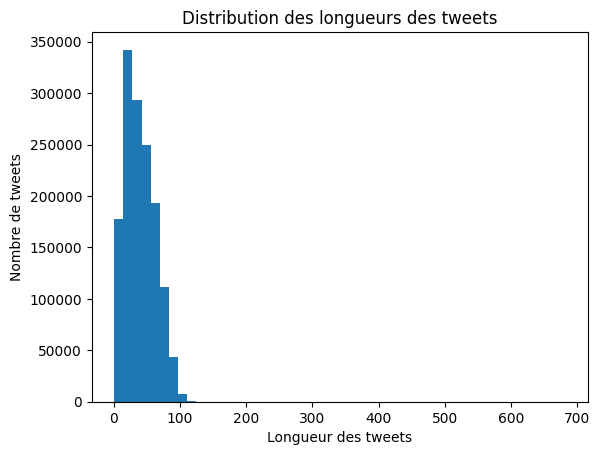

In [ ]:
lengths = [len(t) for t in X_train.values]
plt.hist(lengths, bins=50)
plt.xlabel('Longueur des tweets')
plt.ylabel('Nombre de tweets')
plt.title('Distribution des longueurs des tweets')
plt.show()

In [ ]:
# longth pour couvrir 95% des tweet
np.percentile(lengths, 95)

np.float64(80.0)

In [ ]:
# Paramètres
num_words = 10000
maxlen = 80
embedding_dim = 100
epochs = 5
batch_size = 64

In [ ]:
# Tokenizer
tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

In [ ]:
# Séquences + padding
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

model = Sequential([
    Input(shape=(maxlen,)),
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    Dropout(0.2),
    LSTM(128),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 80, 100)        │    22,406,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,524,277 (85.92 MB)

 Trainable params: 22,524,277 (85.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Set experiment
mlflow.set_experiment("LSTM tweet classifier")

with mlflow.start_run(run_name="LSTM with trainable embedding"):

    # Log tags descriptifs
    mlflow.set_tag("model_type", "LSTM")
    mlflow.set_tag("embedding", "trainable")

    # Log params
    mlflow.log_param("num_words", num_words)
    mlflow.log_param("maxlen", maxlen)
    mlflow.log_param("embedding_dim", embedding_dim)
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", batch_size)

    # Entraînement
    history = model.fit(
        X_train_pad, y_train,
        validation_split=0.1,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )

    # Prédictions
    y_pred = (model.predict(X_test_pad) > 0.5).astype(int)

    # Log des métriques
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    # Signature
    signature = infer_signature(X_test_pad[:1], y_pred[:1])

    # Log du modèle
    mlflow.keras.log_model(
        model,
        artifact_path="lstm_model",
        signature=signature,
        registered_model_name="LSTM_Embedding"
    )
    print("Run MLflow terminé avec succès")

2025/05/14 17:18:13 INFO mlflow.tracking.fluent: Experiment with name 'LSTM tweet classifier' does not exist. Creating a new experiment.


Epoch 1/5
19957/19957 ━━━━━━━━━━━━━━━━━━━━ 376s 19ms/step - accuracy: 0.4999 - loss: 0.6932 - val_accuracy: 0.5014 - val_loss: 0.6931
Epoch 2/5
19957/19957 ━━━━━━━━━━━━━━━━━━━━ 369s 19ms/step - accuracy: 0.5217 - loss: 0.6769 - val_accuracy: 0.7800 - val_loss: 0.4620
Epoch 3/5
19957/19957 ━━━━━━━━━━━━━━━━━━━━ 370s 19ms/step - accuracy: 0.7868 - loss: 0.4511 - val_accuracy: 0.7890 - val_loss: 0.4470
Epoch 4/5
19957/19957 ━━━━━━━━━━━━━━━━━━━━ 368s 18ms/step - accuracy: 0.7971 - loss: 0.4328 - val_accuracy: 0.7918 - val_loss: 0.4437
Epoch 5/5
19957/19957 ━━━━━━━━━━━━━━━━━━━━ 366s 18ms/step - accuracy: 0.8051 - loss: 0.4198 - val_accuracy: 0.7917 - val_loss: 0.4446
4928/4928 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


Successfully registered model 'LSTM_Embedding'.


Run MLflow terminé avec succès


Created version '1' of model 'LSTM_Embedding'.


In [ ]:
# Évaluation sur le jeu de test
loss, acc = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"Loss sur test = {loss:.4f}, Accuracy sur test = {acc:.4f}")

Loss sur test = 0.4431, Accuracy sur test = 0.7920


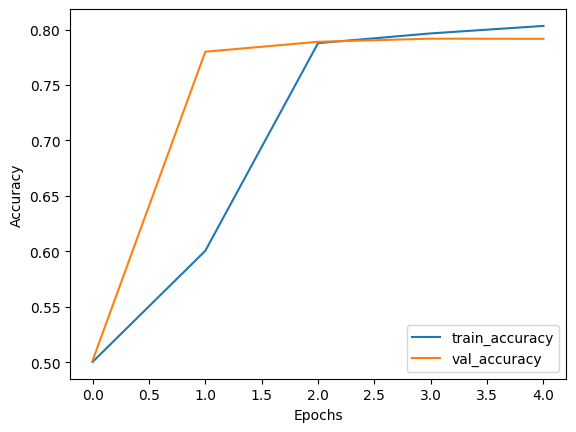

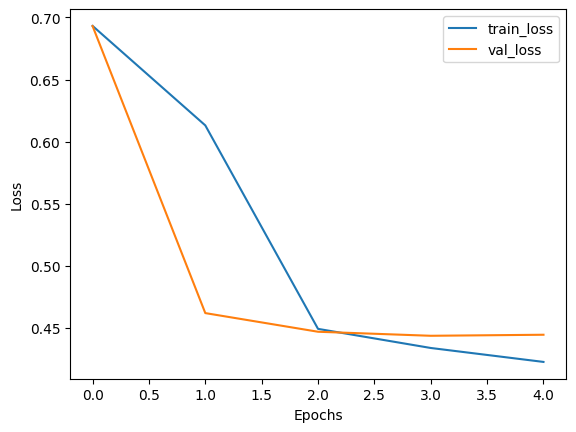

In [ ]:
# Tracer l'accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Tracer la perte (loss)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Modèle LSTM avec embedding pré-entraîné GloVe

In [ ]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

In [ ]:
# save_path = '/content/drive/MyDrive/Openclassrooms/Projet-7/data/glove_data'
# os.makedirs(save_path, exist_ok=True)

In [ ]:
# !mv glove.6B.*.txt /content/drive/MyDrive/Openclassrooms/Projet-7/data/glove_data/

In [ ]:
# Charger les embeddings GloVe
embeddings_index = {}
with open(path + 'data/glove_data/' + 'glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coeffs

print(f"{len(embeddings_index)} mots vectorisés chargés depuis GloVe.")

400000 mots vectorisés chargés depuis GloVe.


In [ ]:
# Un exemple
embeddings_index['king']

array([-0.32307 , -0.87616 ,  0.21977 ,  0.25268 ,  0.22976 ,  0.7388  ,
       -0.37954 , -0.35307 , -0.84369 , -1.1113  , -0.30266 ,  0.33178 ,
       -0.25113 ,  0.30448 , -0.077491, -0.89815 ,  0.092496, -1.1407  ,
       -0.58324 ,  0.66869 , -0.23122 , -0.95855 ,  0.28262 , -0.078848,
        0.75315 ,  0.26584 ,  0.3422  , -0.33949 ,  0.95608 ,  0.065641,
        0.45747 ,  0.39835 ,  0.57965 ,  0.39267 , -0.21851 ,  0.58795 ,
       -0.55999 ,  0.63368 , -0.043983, -0.68731 , -0.37841 ,  0.38026 ,
        0.61641 , -0.88269 , -0.12346 , -0.37928 , -0.38318 ,  0.23868 ,
        0.6685  , -0.43321 , -0.11065 ,  0.081723,  1.1569  ,  0.78958 ,
       -0.21223 , -2.3211  , -0.67806 ,  0.44561 ,  0.65707 ,  0.1045  ,
        0.46217 ,  0.19912 ,  0.25802 ,  0.057194,  0.53443 , -0.43133 ,
       -0.34311 ,  0.59789 , -0.58417 ,  0.068995,  0.23944 , -0.85181 ,
        0.30379 , -0.34177 , -0.25746 , -0.031101, -0.16285 ,  0.45169 ,
       -0.91627 ,  0.64521 ,  0.73281 , -0.22752 , 

In [ ]:
# Créer la matrice d'embedding
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, index in tokenizer.word_index.items():
    if index >= vocab_size:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

print(f"Matrice d'embedding construite avec shape {embedding_matrix.shape}")

Matrice d'embedding construite avec shape (224069, 100)


In [ ]:
# Construire le modèle LSTM (GloVe)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input

model_glove = Sequential([
    Input(shape=(maxlen,)),
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=maxlen,
        trainable=False  # embeddings non-modifiables
    ),
    Dropout(0.2),
    LSTM(128),
    Dense(1, activation='sigmoid')
])

model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_glove.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 80, 100)        │    22,406,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 80, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,524,277 (85.92 MB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 22,406,900 (85.48 MB)

In [ ]:
# Entraînement + MLflow tracking
mlflow.set_experiment("LSTM tweet classifier")

with mlflow.start_run(run_name="LSTM with GloVe 100d") as run:
    # --- Entraînement ---
    history_glove = model_glove.fit(
        X_train_pad, y_train,
        epochs=5,
        batch_size=64,
        validation_split=0.1,
        verbose=1
    )

    # --- Prédiction & métriques ---
    y_pred = model_glove.predict(X_test_pad)
    y_pred = (y_pred > 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # --- Logging paramètres ---
    mlflow.log_param("embedding", "GloVe 100d")
    mlflow.log_param("epochs", 5)
    mlflow.log_param("batch_size", 64)
    mlflow.log_param("embedding_trainable", False)
    mlflow.log_param("vocab_size", vocab_size)
    mlflow.log_param("embedding_dim", embedding_dim)

    # --- Logging métriques ---
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("f1_score", f1)

    # --- Tags ---
    mlflow.set_tag("type", "LSTM")
    mlflow.set_tag("embedding_source", "GloVe")
    mlflow.set_tag("note", "GloVe 100d non-trainable")

    # --- Signature & input example ---
    input_example = X_train_pad[:1]
    signature = infer_signature(input_example, model_glove.predict(input_example))

    # --- Logger modèle Keras ---
    mlflow.keras.log_model(
        model_glove,
        artifact_path="lstm_glove_model",
        signature=signature,
        registered_model_name="LSTM_GloVe"
    )

    print("Modèle GloVe loggué avec MLflow avec succès.")

Epoch 1/5
19957/19957 ━━━━━━━━━━━━━━━━━━━━ 133s 7ms/step - accuracy: 0.5001 - loss: 0.6932 - val_accuracy: 0.4989 - val_loss: 0.6931
Epoch 2/5
19957/19957 ━━━━━━━━━━━━━━━━━━━━ 130s 7ms/step - accuracy: 0.5001 - loss: 0.6931 - val_accuracy: 0.4990 - val_loss: 0.6931
Epoch 3/5
19957/19957 ━━━━━━━━━━━━━━━━━━━━ 131s 7ms/step - accuracy: 0.5617 - loss: 0.6518 - val_accuracy: 0.7459 - val_loss: 0.5085
Epoch 4/5
19957/19957 ━━━━━━━━━━━━━━━━━━━━ 131s 7ms/step - accuracy: 0.7434 - loss: 0.5122 - val_accuracy: 0.7559 - val_loss: 0.4948
Epoch 5/5
19957/19957 ━━━━━━━━━━━━━━━━━━━━ 134s 7ms/step - accuracy: 0.7534 - loss: 0.4986 - val_accuracy: 0.7588 - val_loss: 0.4912
4928/4928 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Modèle GloVe loggué avec MLflow avec succès.


Successfully registered model 'LSTM_GloVe'.
Created version '1' of model 'LSTM_GloVe'.


In [ ]:
y_pred = model_glove.predict(X_test_pad)
y_pred = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
accuracy

4928/4928 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


0.7601311500361487

In [ ]:
loss, acc = model_glove.evaluate(X_test_pad, y_test, verbose=0)
print(f"Accuracy du modèle avec GloVe sur test = {acc:.4f}")

Accuracy du modèle avec GloVe sur test = 0.7601


## Prédire le sentiment d’un nouveau tweet

In [ ]:
def predire_sentiment(tweet_brut: str, model, tokenizer, maxlen=50):

    tweet = preprocess_tweet(tweet_brut, rejoin=True)
    seq = tokenizer.texts_to_sequences([tweet])
    padded = pad_sequences(seq, maxlen=maxlen, padding='post', truncating='post')

    # Prédire le score avec le modèle
    proba = model.predict(padded)[0][0]

    # Interpréter le résultat
    sentiment = "positif" if proba >= 0.5 else "négatif"
    print(f"Tweet: '{tweet_brut}' \n-> Sentiment {sentiment} (score={proba:.3f})")

    return proba

In [ ]:
tweet1 = "I like this new film, it is awsome :)"
predire_sentiment(tweet1, model_glove, tokenizer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tweet: 'I like this new film, it is awsome :)' 
-> Sentiment positif (score=0.892)


np.float32(0.8922199)

In [ ]:
tweet2 = "Bad experience"
predire_sentiment(tweet2, model_glove, tokenizer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tweet: 'Bad experience' 
-> Sentiment négatif (score=0.161)


np.float32(0.16104965)